### Programming Assignment 5
# **Linear Regression**

AJ Dave A. Obis and Juan Francis C. Tuatis

## Import the libraries to be used


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## 1. Load and perform exploratory data analysis

In [11]:
data = pd.read_csv("cyber_attacks(in).csv")

# Transform the data to DataFrame
data_df = pd.DataFrame(data)

# Print the first few rows of the DataFrame
data_df.head()


,protocol_type,duration,src_bytes,dst_bytes,num_packets,num_connections,attack_type
0,1,43.418651,1701.411601,201.794741,42,15,Botnet
1,1,8.587924,409.971403,710.745376,17,6,Normal
2,1,4.386891,418.478693,559.457816,17,5,Normal
3,0,NaN,NaN,NaN,11,3,Normal
4,0,1.061892,494.253699,572.459614,11,3,Normal


### Check the Dataset Contents

In [15]:
# Number of rows and columns in the DataFrame
print("Number of rows: ", data_df.shape[0])
print("Number of columns: ", data_df.shape[1])

Number of rows:  10000
Number of columns:  7


In [14]:
# Check if there are missing values in the dataset
missing_values = data_df.isnull().sum()
print("Missing values: ", + missing_values)

Missing values:  protocol_type        0
duration           500
src_bytes          500
dst_bytes          500
num_packets          0
num_connections      0
attack_type          0
dtype: int64


### Attack Type Frequency

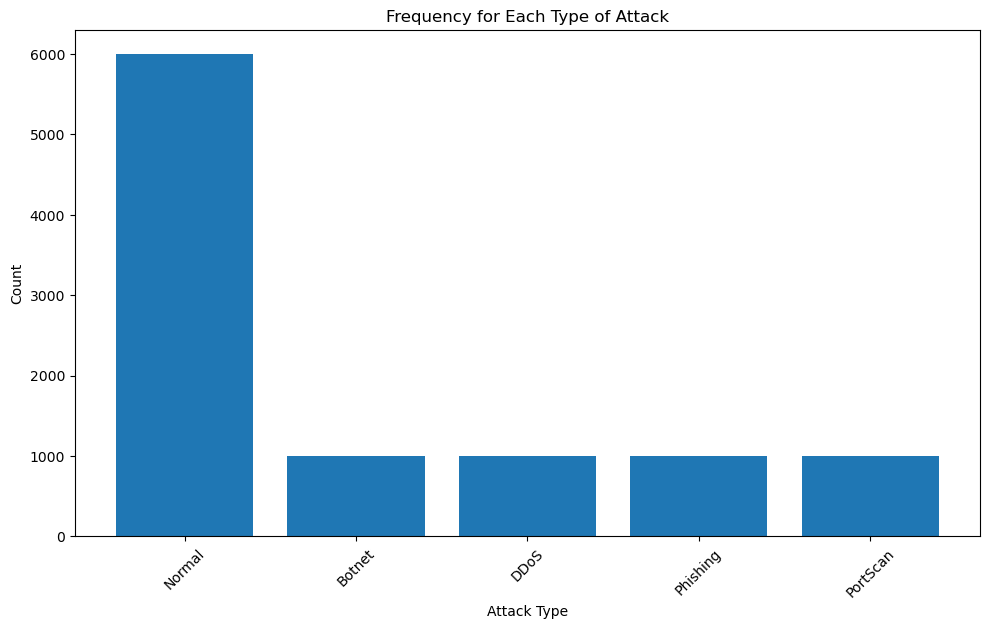

In [ ]:
attack_counts = data_df['attack_type'].value_counts().reset_index()
attack_counts.columns = ['attack_type', 'count']

# Plot the attack counts
plt.figure(figsize=(10,6))
plt.bar(attack_counts['attack_type'], attack_counts['count'])

plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.title('Frequency for Each Type of Attack')

plt.xticks(rotation=45)
plt.show()

### 

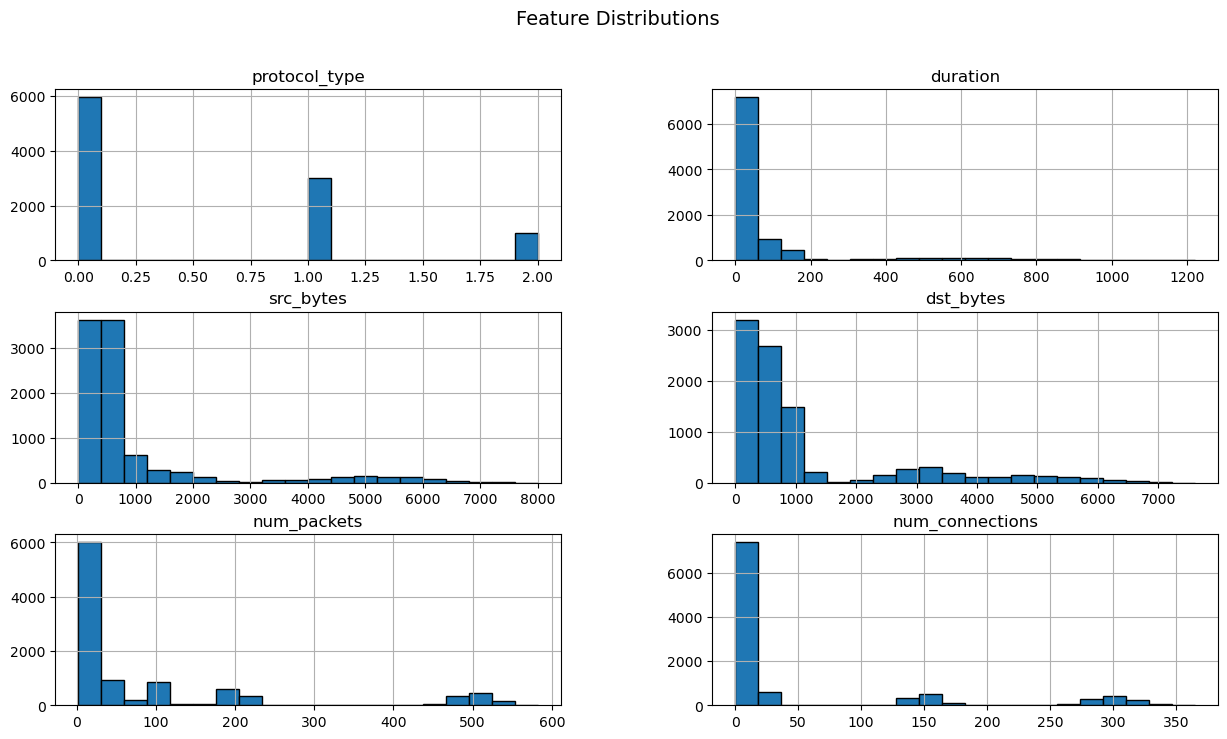

In [25]:
data_df.hist(figsize=(15, 8), bins=20, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

## 2. Perform data preprocessing

### Spliting the Train and Test Data
Split the data into training (70%) and testing (30%) sets.

In [27]:
y = data['attack_type']

X_train, X_test, y_train, y_test = train_test_split(data_df, y, test_size=0.3, random_state=14)